# **Statement of the problem**

**Let's create a hand gesture recognition mode. We use the presented hand gesture recognition database, which consists of a set of images in the near infrared range obtained by the Leap Motion sensor. The database consists of 10 different hand gestures.**

# **As a basis, we will use the pre-trained ResNet50 model.**

  ResNet50 is a deep convolutional neural network architecture for image classification tasks. It was introduced in 2015 and is a 50-layer residual network, hence the name "ResNet50". The residual connections in the network allow for training of very deep neural networks, and ResNet50 has achieved state-of-the-art performance on several benchmark datasets for image classification.

ResNet50 is widely used in a variety of computer vision tasks and applications, including object recognition, image classification, and semantic segmentation, due to its ability to learn robust features and handle large amounts of data. It is also computationally efficient and can be trained using a modest amount of computing resources, making it a popular choice for a wide range of real-world applications.

# install the required dependencies

In [1]:
!pip install torchsummary

In [2]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.8 MB/s eta 0:00:00


In [3]:
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires flatbuffers~=1.12.0, but you have flatbuffers 23.1.21 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=

**Importing the required libraries**

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

In [5]:
DATA_ROOT = Path('/kaggle/input/leapgestrecog/leapGestRecog/')

**Let's save the class names by loading one of the folders:**

In [6]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

**Let's set the transformations for the train and the test. For Grayscale, we set the number of output layers to 3, because resnet does not accept single channel images**

In [7]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
                         tt.ToTensor(),                      # Cast to tensor
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])
     

**Let's create training and test datasets with the same images, but with different preprocessing:**

In [8]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

**Total number of pictures:**

In [9]:
LEN_DS = len(train_ds)
LEN_DS

20000

**The function to convert the class number to its name:**

In [10]:
def digit_to_classname(digit):
    for idx, itm in enumerate(CLASSES_NAME):
        if idx == digit:
            return itm

**Let's look at the distribution of classes in the dataset:**

**This code first counts the number of samples in each class in the training set using the Counter class from the collections module. The Counter object is then used to create a bar plot showing the class distribution in the training set.**

**Similar code can be used to visualize the class distribution in the test set.**

Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000, 6: 2000, 7: 2000, 8: 2000, 9: 2000})


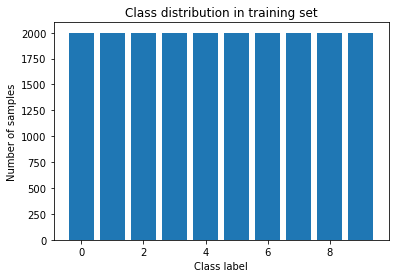

In [11]:
from collections import Counter

train_counts = Counter([label for _, label in train_ds])
print(train_counts)

import matplotlib.pyplot as plt
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in training set')
plt.show()

**Class distribution is equal.**

In [12]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

**Let's check the dimension of the random tensor in the dataset:**

In [13]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

**Let's create dataloaders:**

In [14]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

**Let's display a random image in the test loader:**

torch.Size([3, 128, 128])
tensor(2) 03_fist


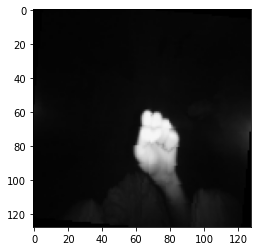

In [15]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

**Function for batch visualization:**

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


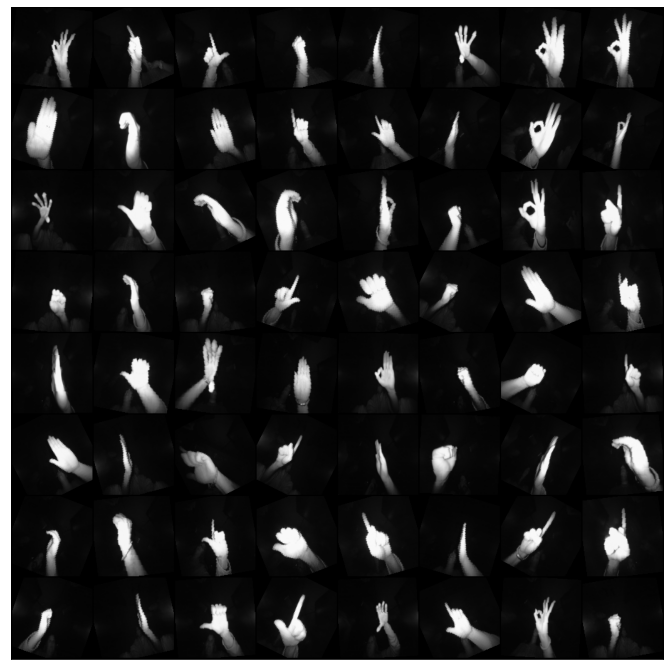

In [17]:
show_batch(train_dl)

**Let's define a device for the operation of neural networks:**

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Let's take a pre-trained network resnet50 for classification:**

In [19]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

**Forbid weights to learn**

In [20]:
for param in resnet.parameters():
    param.requires_grad = False

In [21]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Let's overwrite the last classification layer, and make sure that the rest of the layers will not be trained:**

In [22]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

**Let's create a list of trainable parameters and feed it to the optimizer. We also initialize the loss function:**

In [23]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)


We initialize the function for training the network:

In [24]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

**Let's train the network on 10 epochs:**

In [25]:
print_every = 50
num_epoch = 10

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[10]. Batch [50]/[250]. Train loss 1.367. Train acc 60.062. Val loss 1.333. Val acc 60.950. Took 33.616 seconds
Epoch [1]/[10]. Batch [100]/[250]. Train loss 1.124. Train acc 67.594. Val loss 0.907. Val acc 72.475. Took 33.159 seconds
Epoch [1]/[10]. Batch [150]/[250]. Train loss 0.957. Train acc 72.458. Val loss 0.725. Val acc 80.575. Took 32.923 seconds
Epoch [1]/[10]. Batch [200]/[250]. Train loss 0.845. Train acc 75.672. Val loss 0.651. Val acc 81.225. Took 32.939 seconds
Epoch [1]/[10]. Batch [250]/[250]. Train loss 0.762. Train acc 77.950. Val loss 0.607. Val acc 81.325. Took 32.271 seconds
Epoch took 164.9552788734436
Epoch [2]/[10]. Batch [50]/[250]. Train loss 0.106. Train acc 79.562. Val loss 0.700. Val acc 79.725. Took 33.804 seconds
Epoch [2]/[10]. Batch [100]/[250]. Train loss 0.155. Train acc 82.953. Val loss 0.678. Val acc 79.275. Took 32.244 seconds
Epoch [2]/[10]. Batch [150]/[250]. Train loss 0.186. Train acc 84.281. Val loss 0.642. Val acc 79.800. Took 31.9

**If you need to train the model, you can train the neural network for one more epoch:**

In [26]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=1
)

Epoch [1]/[1]. Batch [50]/[250]. Train loss 0.218. Train acc 92.781. Val loss 0.260. Val acc 92.925. Took 33.609 seconds
Epoch [1]/[1]. Batch [100]/[250]. Train loss 0.186. Train acc 93.969. Val loss 0.228. Val acc 94.450. Took 32.926 seconds
Epoch [1]/[1]. Batch [150]/[250]. Train loss 0.178. Train acc 94.271. Val loss 0.239. Val acc 93.225. Took 32.624 seconds
Epoch [1]/[1]. Batch [200]/[250]. Train loss 0.173. Train acc 94.328. Val loss 0.224. Val acc 93.975. Took 33.106 seconds
Epoch [1]/[1]. Batch [250]/[250]. Train loss 0.169. Train acc 94.563. Val loss 0.234. Val acc 93.100. Took 32.051 seconds
Epoch took 164.3623082637787


**Save and download our model:**

In [27]:
torch.save(resnet, '/kaggle/working/my_model')

In [28]:
resnet = torch.load('/kaggle/working/my_model')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Let's see the predictions for 5 pictures from the test dataset:**

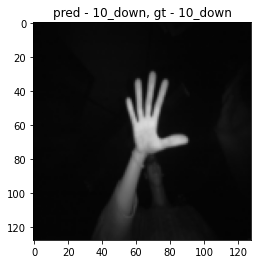

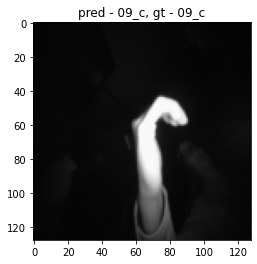

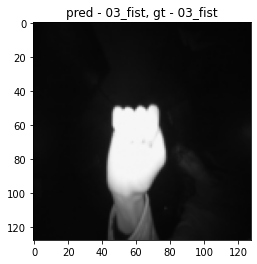

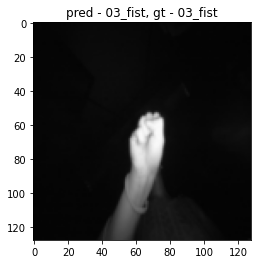

In [29]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

**Everything works great**